# Install requirements

In [ ]:
!pip install lckr-jupyterlab-variableinspector

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


In [ ]:
%load_ext google.colab.data_table


# Implementation of functions we used from the repository

**Permutation Entropy implementation**

In [ ]:
def perm_entropy(x, order=3, delay=1, normalize=False):
    """Permutation Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy. Default is 3.
    delay : int, list, np.ndarray or range
        Time delay (lag). Default is 1. If multiple values are passed
        (e.g. [1, 2, 3]), AntroPy will calculate the average permutation
        entropy across all these delays.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    pe : float
        Permutation Entropy.

    Notes
    -----
    The permutation entropy is a complexity measure for time-series first
    introduced by Bandt and Pompe in 2002.

    The permutation entropy of a signal :math:`x` is defined as:

    .. math:: H = -\\sum p(\\pi)\\log_2(\\pi)

    where the sum runs over all :math:`n!` permutations :math:`\\pi` of order
    :math:`n`. This is the information contained in comparing :math:`n`
    consecutive values of the time series. It is clear that
    :math:`0 ≤ H (n) ≤ \\log_2(n!)` where the lower bound is attained for an
    increasing or decreasing sequence of values, and the upper bound for a
    completely random system where all :math:`n!` possible permutations appear
    with the same probability.

    The embedded matrix :math:`Y` is created by:

    .. math::
        y(i)=[x_i,x_{i+\\text{delay}}, ...,x_{i+(\\text{order}-1) *
        \\text{delay}}]

    .. math:: Y=[y(1),y(2),...,y(N-(\\text{order}-1))*\\text{delay})]^T

    References
    ----------
    Bandt, Christoph, and Bernd Pompe. "Permutation entropy: a
    natural complexity measure for time series." Physical review letters
    88.17 (2002): 174102.

    Examples
    --------
    Permutation entropy with order 2

    >>> import numpy as np
    >>> import antropy as ant
    >>> import stochastic.processes.noise as sn
    >>> x = [4, 7, 9, 10, 6, 11, 3]
    >>> # Return a value in bit between 0 and log2(factorial(order))
    >>> print(f"{ant.perm_entropy(x, order=2):.4f}")
    0.9183

    Normalized permutation entropy with order 3

    >>> # Return a value comprised between 0 and 1.
    >>> print(f"{ant.perm_entropy(x, normalize=True):.4f}")
    0.5888

    Fractional Gaussian noise with H = 0.5, averaged across multiple delays
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ant.perm_entropy(x, delay=[1, 2, 3], normalize=True):.4f}")
    0.9999

    Fractional Gaussian noise with H = 0.1, averaged across multiple delays

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ant.perm_entropy(x, delay=[1, 2, 3], normalize=True):.4f}")
    0.9986

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ant.perm_entropy(rng.random(1000), normalize=True):.4f}")
    0.9997

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ant.perm_entropy(x, normalize=True):.4f}")
    0.4463

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ant.perm_entropy(x, normalize=True):.4f}")
    -0.0000
    """
    # If multiple delay are passed, return the average across all d
    if isinstance(delay, (list, np.ndarray, range)):
        return np.mean([perm_entropy(x, order=order, delay=d, normalize=normalize) for d in delay])
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    assert delay > 0, "delay must be greater than zero."
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind="quicksort")
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -_xlogx(p).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


**Spectral Entropy**

In [ ]:
def spectral_entropy(x, sf, method="fft", nperseg=None, normalize=False, axis=-1):
    """Spectral Entropy.

    Parameters
    ----------
    x : list or np.array
        1D or N-D data.
    sf : float
        Sampling frequency, in Hz.
    method : str
        Spectral estimation method:

        * ``'fft'`` : Fourier Transform (:py:func:`scipy.signal.periodogram`)
        * ``'welch'`` : Welch periodogram (:py:func:`scipy.signal.welch`)
    nperseg : int or None
        Length of each FFT segment for Welch method.
        If None (default), uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.
    axis : int
        The axis along which the entropy is calculated. Default is -1 (last).

    Returns
    -------
    se : float
        Spectral Entropy

    Notes
    -----
    Spectral Entropy is defined to be the Shannon entropy of the power
    spectral density (PSD) of the data:

    .. math:: H(x, sf) =  -\\sum_{f=0}^{f_s/2} P(f) \\log_2[P(f)]

    Where :math:`P` is the normalised PSD, and :math:`f_s` is the sampling
    frequency.

    References
    ----------
    - Inouye, T. et al. (1991). Quantification of EEG irregularity by
      use of the entropy of the power spectrum. Electroencephalography
      and clinical neurophysiology, 79(3), 204-210.

    - https://en.wikipedia.org/wiki/Spectral_density

    - https://en.wikipedia.org/wiki/Welch%27s_method

    Examples
    --------
    Spectral entropy of a pure sine using FFT

    >>> import numpy as np
    >>> import antropy as ant
    >>> sf, f, dur = 100, 1, 4
    >>> N = sf * dur # Total number of discrete samples
    >>> t = np.arange(N) / sf # Time vector
    >>> x = np.sin(2 * np.pi * f * t)
    >>> np.round(ant.spectral_entropy(x, sf, method='fft'), 2)
    0.0

    Spectral entropy of a random signal using Welch's method

    >>> np.random.seed(42)
    >>> x = np.random.rand(3000)
    >>> ant.spectral_entropy(x, sf=100, method='welch')
    6.98004566237139

    Normalized spectral entropy

    >>> ant.spectral_entropy(x, sf=100, method='welch', normalize=True)
    0.9955526198316073

    Normalized spectral entropy of 2D data

    >>> np.random.seed(42)
    >>> x = np.random.normal(size=(4, 3000))
    >>> np.round(ant.spectral_entropy(x, sf=100, normalize=True), 4)
    array([0.9464, 0.9428, 0.9431, 0.9417])

    Fractional Gaussian noise with H = 0.5

    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ant.spectral_entropy(x, sf=100, normalize=True):.4f}")
    0.9505

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ant.spectral_entropy(x, sf=100, normalize=True):.4f}")
    0.8477

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ant.spectral_entropy(x, sf=100, normalize=True):.4f}")
    0.9248
    """
    x = np.asarray(x)
    # Compute and normalize power spectrum
    if method == "fft":
        _, psd = periodogram(x, sf, axis=axis)
    elif method == "welch":
        _, psd = welch(x, sf, nperseg=nperseg, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -_xlogx(psd_norm).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se

**SVD Entropy**

In [ ]:
def svd_entropy(x, order=3, delay=1, normalize=False):
    """Singular Value Decomposition entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of SVD entropy (= length of the embedding dimension).
        Default is 3.
    delay : int
        Time delay (lag). Default is 1.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    svd_e : float
        SVD Entropy

    Notes
    -----
    SVD entropy is an indicator of the number of eigenvectors that are needed
    for an adequate explanation of the data set. In other words, it measures
    the dimensionality of the data.

    The SVD entropy of a signal :math:`x` is defined as:

    .. math::
        H = -\\sum_{i=1}^{M} \\overline{\\sigma}_i log_2(\\overline{\\sigma}_i)

    where :math:`M` is the number of singular values of the embedded matrix
    :math:`Y` and :math:`\\sigma_1, \\sigma_2, ..., \\sigma_M` are the
    normalized singular values of :math:`Y`.

    The embedded matrix :math:`Y` is created by:

    .. math::
        y(i)=[x_i,x_{i+\\text{delay}}, ...,x_{i+(\\text{order}-1) *
        \\text{delay}}]

    .. math:: Y=[y(1),y(2),...,y(N-(\\text{order}-1))*\\text{delay})]^T

    Examples
    --------
    SVD entropy with order 2

    >>> import numpy as np
    >>> import antropy as ant
    >>> import stochastic.processes.noise as sn
    >>> x = [4, 7, 9, 10, 6, 11, 3]
    >>> # Return a value in bit between 0 and log2(factorial(order))
    >>> print(ant.svd_entropy(x, order=2))
    0.7618909465130066

    Normalized SVD entropy with order 3

    >>> x = [4, 7, 9, 10, 6, 11, 3]
    >>> # Return a value comprised between 0 and 1.
    >>> print(ant.svd_entropy(x, order=3, normalize=True))
    0.6870083043946692

    Fractional Gaussian noise with H = 0.5

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ant.svd_entropy(x, normalize=True):.4f}")
    1.0000

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ant.svd_entropy(x, normalize=True):.4f}")
    0.9080

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ant.svd_entropy(x, normalize=True):.4f}")
    0.9637

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ant.svd_entropy(rng.random(1000), normalize=True):.4f}")
    0.8527

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ant.svd_entropy(x, normalize=True):.4f}")
    0.1775

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ant.svd_entropy(x, normalize=True):.4f}")
    0.0053
    """
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -_xlogx(W).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e


**Approximate Entropy**

In [ ]:
def app_entropy(x, order=2, tolerance=None, metric="chebyshev"):
    """Approximate Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times).
    order : int
        Embedding dimension. Default is 2.
    tolerance : float
        Tolerance value for acceptance of the template vector. Default is 0.2
        times the standard deviation of x.
    metric : str
        Name of the distance metric function used with
        :py:class:`sklearn.neighbors.KDTree`. Default is to use the
        `Chebyshev <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
        distance.
    Returns
    -------
    ae : float
        Approximate Entropy.

    Notes
    -----
    Approximate entropy is a technique used to quantify the amount of
    regularity and the unpredictability of fluctuations over time-series data.
    Smaller values indicates that the data is more regular and predictable.

    The default tolerance value (:math:`r`) is set to :math:`0.2 * \\text{std}(x)`.

    Code adapted from the `mne-features <https://mne.tools/mne-features/>`_
    package by Jean-Baptiste Schiratti and Alexandre Gramfort.

    References
    ----------
    Richman, J. S. et al. (2000). Physiological time-series analysis
    using approximate entropy and sample entropy. American Journal of
    Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.

    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

    Examples
    --------
    Fractional Gaussian noise with H = 0.5

    >>> import numpy as np
    >>> import antropy as ant
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ant.app_entropy(x, order=2):.4f}")
    2.1958

    Same with order = 3 and metric = 'euclidean'

    >>> print(f"{ant.app_entropy(x, order=3, metric='euclidean'):.4f}")
    1.5120

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ant.app_entropy(x):.4f}")
    1.9681

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ant.app_entropy(x):.4f}")
    2.0906

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ant.app_entropy(rng.random(1000)):.4f}")
    1.8177

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ant.app_entropy(x):.4f}")
    0.2009

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ant.app_entropy(x):.4f}")
    -0.0010
    """
    # define r
    if tolerance is None:
        r = 0.2 * np.std(x, ddof=0)
    else:
        assert isinstance(tolerance, (float, int))
        r = tolerance
    phi = _app_samp_entropy(x, order=order, r=r, metric=metric, approximate=True)
    return np.subtract(phi[0], phi[1])


**Sample Entropy**

In [ ]:
def sample_entropy(x, order=2, tolerance=None, metric="chebyshev"):
    """Sample Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times).
    order : int
        Embedding dimension. Default is 2.
    tolerance : float
        Tolerance value for acceptance of the template vector. Default is 0.2
        times the standard deviation of x.
    metric : str
        Name of the distance metric function used with
        :py:class:`sklearn.neighbors.KDTree`. Default is to use the
        `Chebyshev <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
        distance.

    Returns
    -------
    se : float
        Sample Entropy.

    Notes
    -----
    Sample entropy is a modification of approximate entropy, used for assessing
    the complexity of physiological time-series signals. It has two advantages
    over approximate entropy: data length independence and a relatively
    trouble-free implementation. Large values indicate high complexity whereas
    smaller values characterize more self-similar and regular signals.

    The sample entropy of a signal :math:`x` is defined as:

    .. math:: H(x, m, r) = -\\log\\frac{C(m + 1, r)}{C(m, r)}

    where :math:`m` is the embedding dimension (= order), :math:`r` is
    the radius of the neighbourhood (default = :math:`0.2 * \\text{std}(x)`),
    :math:`C(m + 1, r)` is the number of embedded vectors of length
    :math:`m + 1` having a
    `Chebyshev distance <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
    inferior to :math:`r` and :math:`C(m, r)` is the number of embedded
    vectors of length :math:`m` having a Chebyshev distance inferior to
    :math:`r`.

    Note that if ``metric == 'chebyshev'`` and ``len(x) < 5000`` points,
    then the sample entropy is computed using a fast custom Numba script.
    For other distance metric or longer time-series, the sample entropy is
    computed using a code from the
    `mne-features <https://mne.tools/mne-features/>`_ package by Jean-Baptiste
    Schiratti and Alexandre Gramfort (requires sklearn).

    References
    ----------
    Richman, J. S. et al. (2000). Physiological time-series analysis
    using approximate entropy and sample entropy. American Journal of
    Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.

    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

    Examples
    --------
    Fractional Gaussian noise with H = 0.5

    >>> import numpy as np
    >>> import antropy as ant
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ant.sample_entropy(x, order=2):.4f}")
    2.1819

    Same with order = 3 and using the Euclidean distance

    >>> print(f"{ant.sample_entropy(x, order=3, metric='euclidean'):.4f}")
    2.6806

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ant.sample_entropy(x):.4f}")
    1.9078

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ant.sample_entropy(x):.4f}")
    2.0555

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ant.sample_entropy(rng.random(1000)):.4f}")
    2.2017

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ant.sample_entropy(x):.4f}")
    0.1633

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ant.sample_entropy(x):.4f}")
    -0.0000
    """
    # define r
    if tolerance is None:
        r = 0.2 * np.std(x, ddof=0)
    else:
        assert isinstance(tolerance, (float, int))
        r = tolerance
    x = np.asarray(x, dtype=np.float64)
    if metric == "chebyshev" and x.size < 5000:
        return _numba_sampen(x, order=order, r=r)
    else:
        phi = _app_samp_entropy(x, order=order, r=r, metric=metric, approximate=False)
        return -np.log(np.divide(phi[1], phi[0]))

**Lempel-Ziv (LZ) complexity**

In [ ]:
def lziv_complexity(sequence, normalize=False):
    """
    Lempel-Ziv (LZ) complexity of (binary) sequence.

    .. versionadded:: 0.1.1

    Parameters
    ----------
    sequence : str or array
        A sequence of character, e.g. ``'1001111011000010'``,
        ``[0, 1, 0, 1, 1]``, or ``'Hello World!'``.
    normalize : bool
        If ``True``, returns the normalized LZ (see Notes).

    Returns
    -------
    lz : int or float
        LZ complexity, which corresponds to the number of different
        substrings encountered as the stream is viewed from the
        beginning to the end. If ``normalize=False``, the output is an
        integer (counts), otherwise the output is a float.

    Notes
    -----
    LZ complexity is defined as the number of different substrings encountered
    as the sequence is viewed from begining to the end.

    Although the raw LZ is an important complexity indicator, it is heavily
    influenced by sequence length (longer sequence will result in higher LZ).
    Zhang and colleagues (2009) have therefore proposed the normalized LZ,
    which is defined by

    .. math:: \\text{LZn} = \\frac{\\text{LZ}}{(n / \\log_b{n})}

    where :math:`n` is the length of the sequence and :math:`b` the number of
    unique characters in the sequence.

    References
    ----------
    * Lempel, A., & Ziv, J. (1976). On the Complexity of Finite Sequences.
      IEEE Transactions on Information Theory / Professional Technical
      Group on Information Theory, 22(1), 75–81.
      https://doi.org/10.1109/TIT.1976.1055501
    * Zhang, Y., Hao, J., Zhou, C., & Chang, K. (2009). Normalized
      Lempel-Ziv complexity and its application in bio-sequence analysis.
      Journal of Mathematical Chemistry, 46(4), 1203–1212.
      https://doi.org/10.1007/s10910-008-9512-2
    * https://en.wikipedia.org/wiki/Lempel-Ziv_complexity
    * https://github.com/Naereen/Lempel-Ziv_Complexity

    Examples
    --------
    >>> from antropy import lziv_complexity
    >>> # Substrings = 1 / 0 / 01 / 1110 / 1100 / 0010
    >>> s = '1001111011000010'
    >>> lziv_complexity(s)
    6

    Using a list of integer / boolean instead of a string

    >>> # 1 / 0 / 10
    >>> lziv_complexity([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
    3

    With normalization

    >>> lziv_complexity(s, normalize=True)
    1.5

    This function also works with characters and words

    >>> s = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    >>> lziv_complexity(s), lziv_complexity(s, normalize=True)
    (26, 1.0)

    >>> s = 'HELLO WORLD! HELLO WORLD! HELLO WORLD! HELLO WORLD!'
    >>> lziv_complexity(s), lziv_complexity(s, normalize=True)
    (11, 0.38596001132145313)
    """
    assert isinstance(sequence, (str, list, np.ndarray))
    assert isinstance(normalize, bool)
    if isinstance(sequence, (list, np.ndarray)):
        sequence = np.asarray(sequence)
        if sequence.dtype.kind in "bfi":
            # Convert [True, False] or [1., 0.] to [1, 0]
            s = sequence.astype("uint32")
        else:
            # Treat as numpy array of strings
            # Map string characters to utf-8 integer representation
            s = np.fromiter(map(ord, "".join(sequence.astype(str))), dtype="uint32")
            # Can't preallocate length (by specifying count) due to string
            # concatenation
    else:
        s = np.fromiter(map(ord, sequence), dtype="uint32")

    if normalize:
        # 1) Timmermann et al. 2019
        # The sequence is randomly shuffled, and the normalized LZ
        # is calculated as the ratio of the LZ of the original sequence
        # divided by the LZ of the randomly shuffled LZ. However, the final
        # output is dependent on the random seed.
        # sl_shuffled = list(s)
        # rng = np.random.RandomState(None)
        # rng.shuffle(sl_shuffled)
        # s_shuffled = ''.join(sl_shuffled)
        # return _lz_complexity(s) / _lz_complexity(s_shuffled)
        # 2) Zhang et al. 2009
        n = len(s)
        base = sum(np.bincount(s) > 0)  # Number of unique characters
        base = 2 if base < 2 else base
        return _lz_complexity(s) / (n / log(n, base))
    else:
        return _lz_complexity(s)



# Adding library of complexity and entropy measurements to our data set

AntroPy is a Python 3 package providing several time-efficient algorithms for computing the complexity of time-series. It can be used for example to extract features from EEG signals.

Install Antropy

In [ ]:
pip install antropy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.9 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=795182b83faf9066b68e6792e7c9e7c7f337902eaba963c0290162573ae38d64
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [ ]:
import numpy as np
import antropy as ant

**Loading different data sets we want to use**

In [ ]:
# load .mat data from drive

from google.colab import drive
drive.mount('/content/drive')

import scipy.io as sio

mat_data = sio.loadmat('/content/drive/MyDrive/Biomarker analysis/subjectsData_fs1000.mat')


Mounted at /content/drive


In [ ]:
CompleteData = mat_data['subjects_data']

HealthyData = CompleteData[0,0]
PatientDataMedoff = CompleteData[0,1]
PatientDataMedon = CompleteData[0,2]

In [ ]:
TrialSample=HealthyData[1,1]
print(TrialSample.shape)

(60000, 1)


In [ ]:
print(HealthyData.shape)
print(PatientDataMedoff.shape)
print(PatientDataMedon.shape)

(22, 27)
(20, 27)
(20, 27)


# Checking the model

In [ ]:
x = [4, 7, 9, 10, 6, 11, 3]
# Return a value in bit between 0 and log2(factorial(order))
print(f"{ant.perm_entropy(x, order=3):.4f}")

1.5219


**Sample of entropy measurements for a random signal**

In [ ]:
import numpy as np
import antropy as ant
np.random.seed(1234567)
x = np.random.normal(size=3000)
# Permutation entropy
print(ant.perm_entropy(x, normalize=True))
# Spectral entropy
print(ant.spectral_entropy(x, sf=100, method='welch', normalize=True))
# Singular value decomposition entropy
print(ant.svd_entropy(x, normalize=True))
# Approximate entropy
print(ant.app_entropy(x))
# Sample entropy
print(ant.sample_entropy(x))
# Hjorth mobility and complexity
print(ant.hjorth_params(x))
# Number of zero-crossings
print(ant.num_zerocross(x))
# Lempel-Ziv complexity
print(ant.lziv_complexity('01111000011001', normalize=True))

0.9995371694290869
0.9940882825422431
0.9999110978316078
2.015221318528564
2.198595813245399
(1.4313385010057378, 1.215335712274099)
1531
1.3597696150205727


In [ ]:
x = TrialSample.transpose()
x=x.flatten()
print(x.shape);

(60000,)


In [ ]:
# Permutation entropy
print(ant.perm_entropy(x, normalize=True))
# Spectral entropy
print(ant.spectral_entropy(x, sf=1000, method='welch', normalize=True))
# Singular value decomposition entropy
print(ant.svd_entropy(x, normalize=True))
# Approximate entropy
print(ant.app_entropy(x))
# Sample entropy
print(ant.sample_entropy(x))
# Hjorth mobility and complexity
print(ant.hjorth_params(x))
# Number of zero-crossings
print(ant.num_zerocross(x))
# Lempel-Ziv complexity
print(ant.lziv_complexity('01111000011001', normalize=True))

0.5473472945210863
0.4443532869108043
0.29927730807742176
0.5047683922359933
0.44342538948080407
(0.12080514146018125, 1.7151503727434065)
2347
1.3597696150205727


# Start main analysis of Entropy measurments

**Defining Constant variables**

In [ ]:
SubjectsN_Healthy=HealthyData.shape[0]
SubjectsN_PatientMedoff=PatientDataMedoff.shape[0]
SubjectsN_PatientMedon=PatientDataMedon.shape[0]
ElectrodesN=HealthyData.shape[1]
SampleFreq=1000
RecordingTime=60

**1-Permutation Entropy**

In [ ]:
# First we use PeEn (permutation entropy) measurements of 3 data sets
perm_entropy_healthy=np.zeros((SubjectsN_Healthy,ElectrodesN))
perm_entropy_patientMedoff=np.zeros((SubjectsN_PatientMedoff,ElectrodesN))
perm_entropy_patientMedon=np.zeros((SubjectsN_PatientMedon,ElectrodesN))

# Healthy Control
for i in range(SubjectsN_Healthy):
  for j in range(ElectrodesN):
    x=HealthyData[i,j]
    x=x.transpose()
    x=x.flatten()
    perm_entropy_healthy[i,j]=ant.perm_entropy(x, normalize=True)

# Medoff
for i in range(SubjectsN_PatientMedoff):
  for j in range(ElectrodesN):
    x=PatientDataMedoff[i,j]
    x=x.transpose()
    x=x.flatten()
    perm_entropy_patientMedoff[i,j]=ant.perm_entropy(x, normalize=True)

# Medon
for i in range(SubjectsN_PatientMedon):
  for j in range(ElectrodesN):
    x=PatientDataMedon[i,j]
    x=x.transpose()
    x=x.flatten()
    perm_entropy_patientMedon[i,j]=ant.perm_entropy(x, normalize=True)


# Print mean of all 3 perm entropy metrices
print(np.mean(perm_entropy_healthy))
print(np.mean(perm_entropy_patientMedoff))
print(np.mean(perm_entropy_patientMedon))






0.5506703265960206
0.5489589684728698
0.5421507809379736


**Plot Box plots**

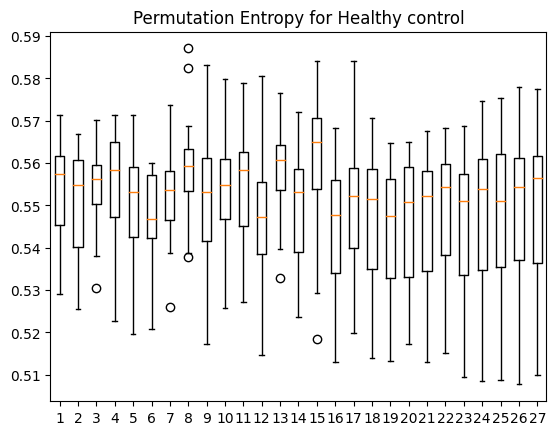

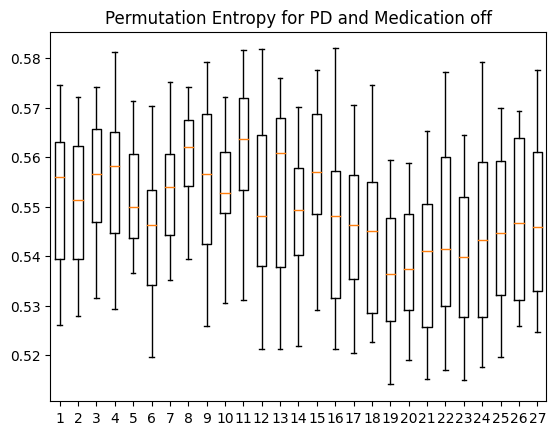

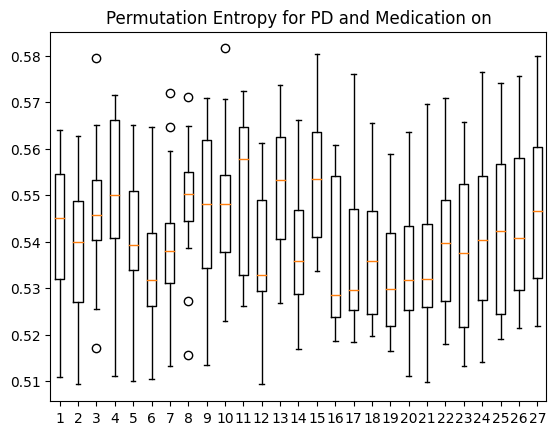

In [ ]:
#Print boxplots of all 3 measurements based on subjects and electrodes

import matplotlib.pyplot as plt
plt.boxplot(perm_entropy_healthy)
plt.title('Permutation Entropy for Healthy control')
plt.show()
plt.boxplot(perm_entropy_patientMedoff)
plt.title('Permutation Entropy for PD and Medication off')
plt.show()
plt.boxplot(perm_entropy_patientMedon)
plt.title('Permutation Entropy for PD and Medication on')
plt.show()

#title of plot


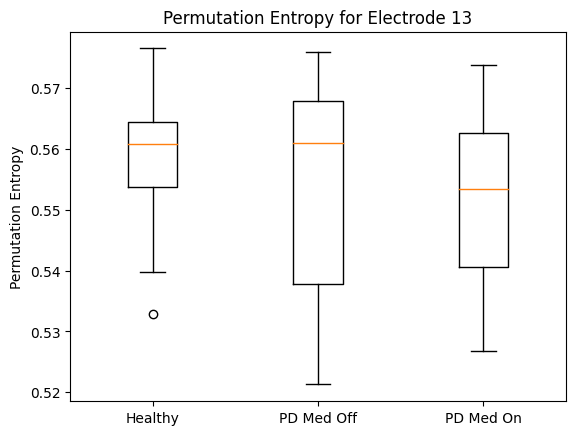

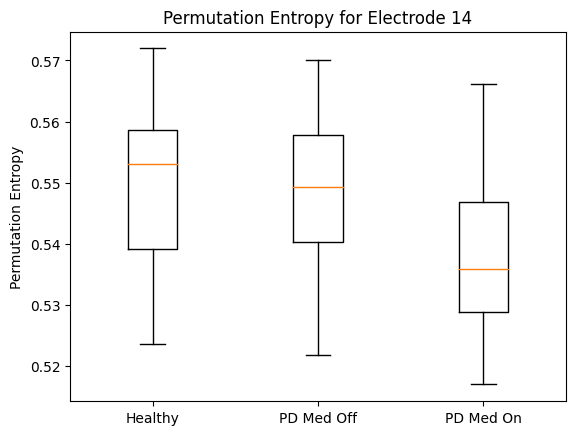

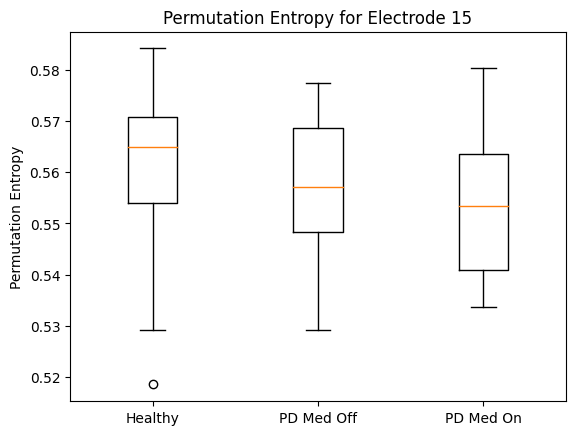

In [ ]:
# prompt: Plot the 13th 14th 15th electrodes in different 3 figures for all 3 data (in each figure we have one electrode and 3 types of data)

import matplotlib.pyplot as plt

# Assuming perm_entropy_healthy, perm_entropy_patientMedoff, and perm_entropy_patientMedon are defined

electrodes_to_plot = [12, 13, 14]  # 13th, 14th, 15th electrodes (Python indexing starts at 0)

for electrode_index in electrodes_to_plot:
  data_to_plot = [
      perm_entropy_healthy[:, electrode_index],
      perm_entropy_patientMedoff[:, electrode_index],
      perm_entropy_patientMedon[:, electrode_index]
  ]
  labels = ['Healthy', 'PD Med Off', 'PD Med On']

  plt.figure()  # Create a new figure for each electrode
  plt.boxplot(data_to_plot, labels=labels)
  plt.title(f'Permutation Entropy for Electrode {electrode_index + 1}')
  plt.ylabel('Permutation Entropy')
  plt.show()



In [ ]:
# prompt: do exactly what you did for permutation entropy for approximate entropy

# **2-Approximate Entropy**
# First we use ApEn measurements of 3 data sets
app_entropy_healthy=np.zeros((SubjectsN_Healthy,ElectrodesN))
app_entropy_patientMedoff=np.zeros((SubjectsN_PatientMedoff,ElectrodesN))
app_entropy_patientMedon=np.zeros((SubjectsN_PatientMedon,ElectrodesN))

# Healthy Control
for i in range(SubjectsN_Healthy):
  for j in range(ElectrodesN):
    x=HealthyData[i,j]
    x=x.transpose()
    x=x.flatten()
    app_entropy_healthy[i,j]=ant.app_entropy(x)

# Medoff
for i in range(SubjectsN_PatientMedoff):
  for j in range(ElectrodesN):
    x=PatientDataMedoff[i,j]
    x=x.transpose()
    x=x.flatten()
    app_entropy_patientMedoff[i,j]=ant.app_entropy(x)

# Medon
for i in range(SubjectsN_PatientMedon):
  for j in range(ElectrodesN):
    x=PatientDataMedon[i,j]
    x=x.transpose()
    x=x.flatten()
    app_entropy_patientMedon[i,j]=ant.app_entropy(x)


# Print mean of all 3 app entropy metrices
print(np.mean(app_entropy_healthy))
print(np.mean(app_entropy_patientMedoff))
print(np.mean(app_entropy_patientMedon))



0.5127987372427177
0.4776246409911941
0.45866959070472074


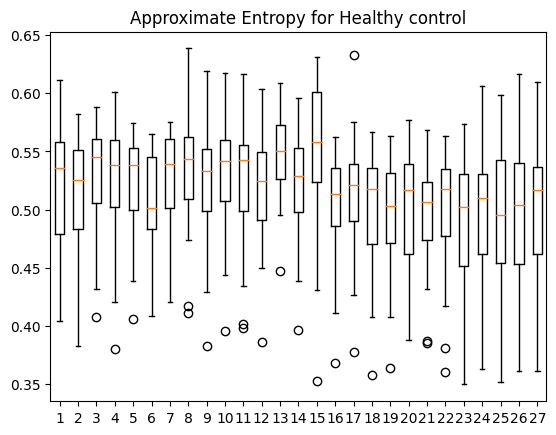

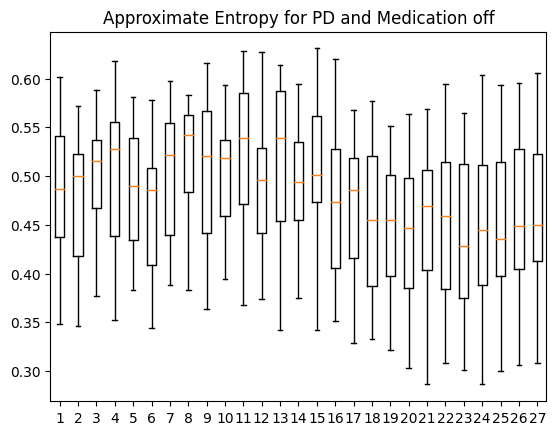

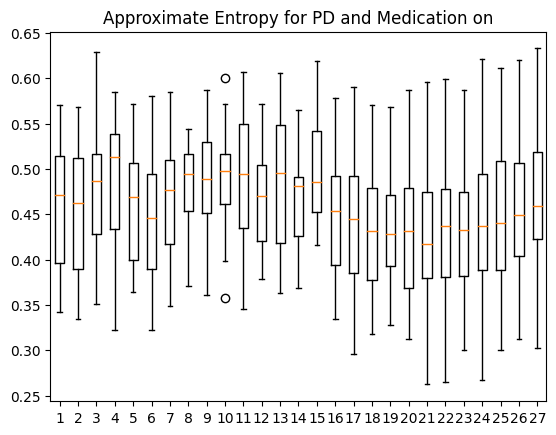

In [ ]:
# **Plot Box plots**
#Print boxplots of all 3 measurements based on subjects and electrodes

plt.boxplot(app_entropy_healthy)
plt.title('Approximate Entropy for Healthy control')
plt.show()
plt.boxplot(app_entropy_patientMedoff)
plt.title('Approximate Entropy for PD and Medication off')
plt.show()
plt.boxplot(app_entropy_patientMedon)
plt.title('Approximate Entropy for PD and Medication on')
plt.show()

#title of plot


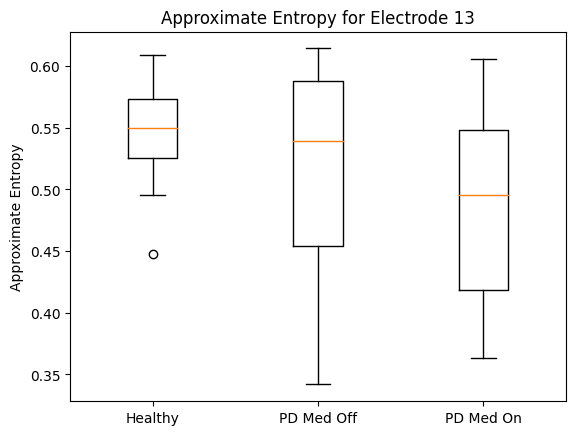

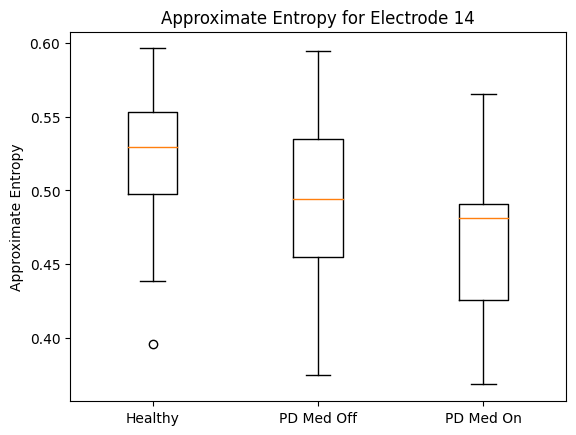

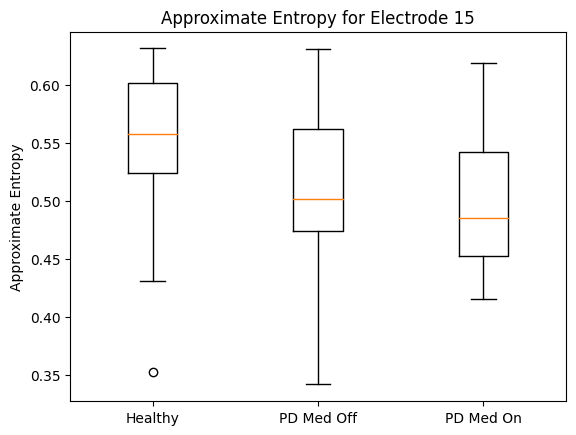

In [ ]:
# Assuming app_entropy_healthy, app_entropy_patientMedoff, and app_entropy_patientMedon are defined

electrodes_to_plot = [12, 13, 14]  # 13th, 14th, 15th electrodes (Python indexing starts at 0)

for electrode_index in electrodes_to_plot:
  data_to_plot = [
      app_entropy_healthy[:, electrode_index],
      app_entropy_patientMedoff[:, electrode_index],
      app_entropy_patientMedon[:, electrode_index]
  ]
  labels = ['Healthy', 'PD Med Off', 'PD Med On']

  plt.figure()  # Create a new figure for each electrode
  plt.boxplot(data_to_plot, labels=labels)
  plt.title(f'Approximate Entropy for Electrode {electrode_index + 1}')
  plt.ylabel('Approximate Entropy')
  plt.show()

In [ ]:
#save 3 approximate entropy measurments
np.save('app_entropy_healthy.npy', app_entropy_healthy)
np.save('app_entropy_patientMedoff.npy', app_entropy_patientMedoff)
np.save('app_entropy_patientMedon.npy', app_entropy_patientMedon)

In [ ]:
import numpy as np
import os

# Specify the directory where you want to save the files
save_directory = '/content/drive/MyDrive/Biomarker analysis/'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the files with the full path
np.save(os.path.join(save_directory, 'app_entropy_healthy.npy'), app_entropy_healthy)
np.save(os.path.join(save_directory, 'app_entropy_patientMedoff.npy'), app_entropy_patientMedoff)
np.save(os.path.join(save_directory, 'app_entropy_patientMedon.npy'), app_entropy_patientMedon)

**Sample Entropy**

In [ ]:
# prompt: prompt: do exactly what you did for permutation entropy for sample entropy

# **3-Sample Entropy**
# First we use SampEn measurements of 3 data sets
samp_entropy_healthy=np.zeros((SubjectsN_Healthy,ElectrodesN))
samp_entropy_patientMedoff=np.zeros((SubjectsN_PatientMedoff,ElectrodesN))
samp_entropy_patientMedon=np.zeros((SubjectsN_PatientMedon,ElectrodesN))

# Healthy Control
for i in range(SubjectsN_Healthy):
  for j in range(ElectrodesN):
    x=HealthyData[i,j]
    x=x.transpose()
    x=x.flatten()
    samp_entropy_healthy[i,j]=ant.sample_entropy(x)

# Medoff
for i in range(SubjectsN_PatientMedoff):
  for j in range(ElectrodesN):
    x=PatientDataMedoff[i,j]
    x=x.transpose()
    x=x.flatten()
    samp_entropy_patientMedoff[i,j]=ant.sample_entropy(x)

# Medon
for i in range(SubjectsN_PatientMedon):
  for j in range(ElectrodesN):
    x=PatientDataMedon[i,j]
    x=x.transpose()
    x=x.flatten()
    samp_entropy_patientMedon[i,j]=ant.sample_entropy(x)


# Print mean of all 3 samp entropy metrices
print(np.mean(samp_entropy_healthy))
print(np.mean(samp_entropy_patientMedoff))
print(np.mean(samp_entropy_patientMedon))




0.4495912329937701
0.4194187644553802
0.4010504845467623


NameError: name 'plt' is not defined

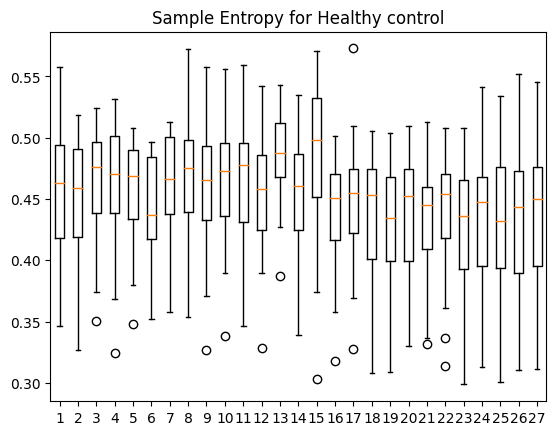

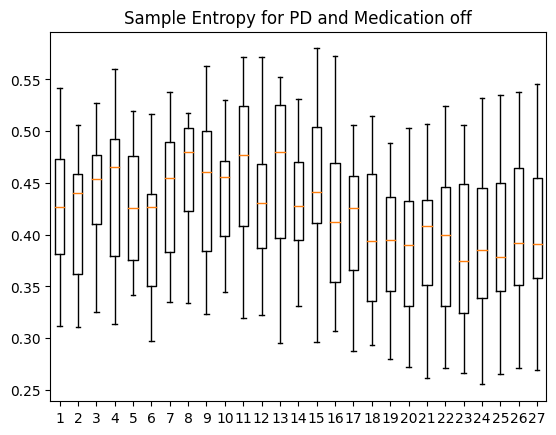

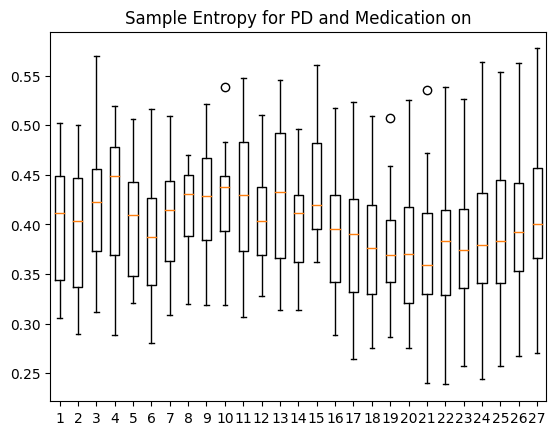

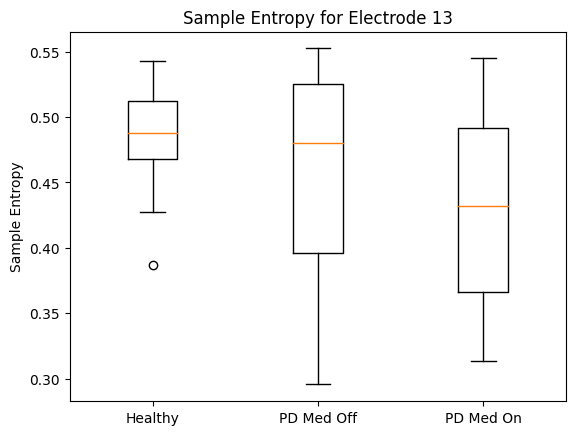

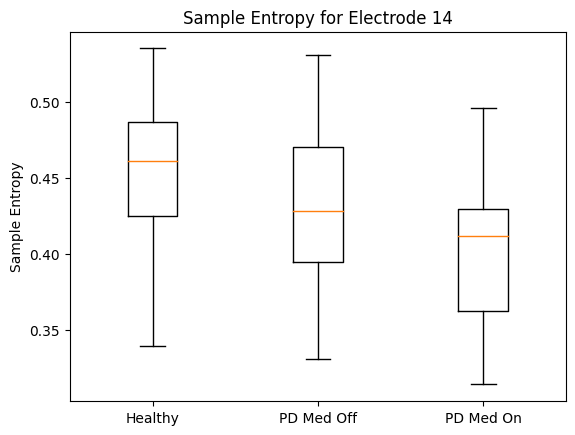

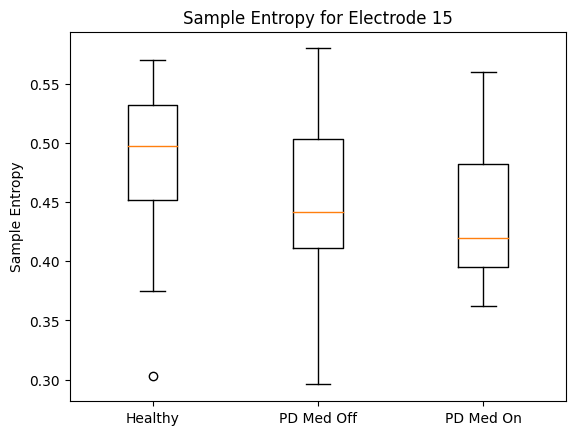

In [ ]:
# **Plot Box plots**
#Print boxplots of all 3 measurements based on subjects and electrodes
import matplotlib.pyplot as plt
import os

plt.boxplot(samp_entropy_healthy)
plt.title('Sample Entropy for Healthy control')
plt.show()
plt.boxplot(samp_entropy_patientMedoff)
plt.title('Sample Entropy for PD and Medication off')
plt.show()
plt.boxplot(samp_entropy_patientMedon)
plt.title('Sample Entropy for PD and Medication on')
plt.show()

#title of plot

# Assuming samp_entropy_healthy, samp_entropy_patientMedoff, and samp_entropy_patientMedon are defined

electrodes_to_plot = [12, 13, 14]  # 13th, 14th, 15th electrodes (Python indexing starts at 0)

for electrode_index in electrodes_to_plot:
  data_to_plot = [
      samp_entropy_healthy[:, electrode_index],
      samp_entropy_patientMedoff[:, electrode_index],
      samp_entropy_patientMedon[:, electrode_index]
  ]
  labels = ['Healthy', 'PD Med Off', 'PD Med On']

  plt.figure()  # Create a new figure for each electrode
  plt.boxplot(data_to_plot, labels=labels)
  plt.title(f'Sample Entropy for Electrode {electrode_index + 1}')
  plt.ylabel('Sample Entropy')
  plt.show()


#save 3 sample entropy measurments
np.save('samp_entropy_healthy.npy', samp_entropy_healthy)
np.save('samp_entropy_patientMedoff.npy', samp_entropy_patientMedoff)
np.save('samp_entropy_patientMedon.npy', samp_entropy_patientMedon)

# Specify the directory where you want to save the files
save_directory = '/content/drive/MyDrive/Biomarker analysis/'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the files with the full path
np.save(os.path.join(save_directory, 'samp_entropy_healthy.npy'), samp_entropy_healthy)
np.save(os.path.join(save_directory, 'samp_entropy_patientMedoff.npy'), samp_entropy_patientMedoff)
np.save(os.path.join(save_directory, 'samp_entropy_patientMedon.npy'), samp_entropy_patientMedon)
